## feature 1 : face mesh - swap

In [2]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

from devlib import *

# Load face mesh model
mpFaceMesh = mp.solutions.face_mesh
faceMesh = mpFaceMesh.FaceMesh(max_num_faces=1)


# main 
# 1. 이미지 로드
frame = cv2.imread("image1.jpg")
img1 = cv2.imread("image2.jpg")

# 2. landmarks detection
points1, img1 = getPoints(img1,cv2.COLOR_BGR2RGB,True)
points2, frame = getPoints(frame,cv2.COLOR_BGR2RGB,True)

img_draw = frame.copy()

# 3. 볼록 선체(convex hull) 구하기 
hullInedx = cv2.convexHull(np.array(points2),returnPoints=False)
hull1 = [points1[int(idx)] for idx in hullInedx]
hull2 = [points2[int(idx)] for idx in hullInedx]

# 4. 볼록 선체 안 들로네 삼각형 좌표 구하기
triangles = getTriangles(frame,hull2)

# 5. 각 삼각형 좌표로 어핀 변환
for i in range(0,len(triangles)):
    t1 = [hull1[triangles[i][j]] for j in range(3)]
    t2 = [hull2[triangles[i][j]] for j in range(3)]
    warpTriangle(img1,img_draw,t1,t2)
    
# 6. 볼록 선체를 마스크로 써서 얼굴 합성
mask = np.zeros(frame.shape[:2],dtype=frame.dtype)
cv2.fillConvexPoly(mask,np.int32(hull2),(255,255,255))
r = cv2.boundingRect(np.float32(hull2))
center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))
output = cv2.seamlessClone(np.uint8(img_draw),frame,mask,center,cv2.NORMAL_CLONE)

plt.imshow(output)
plt.show()

AttributeError: 'NoneType' object has no attribute 'shape'

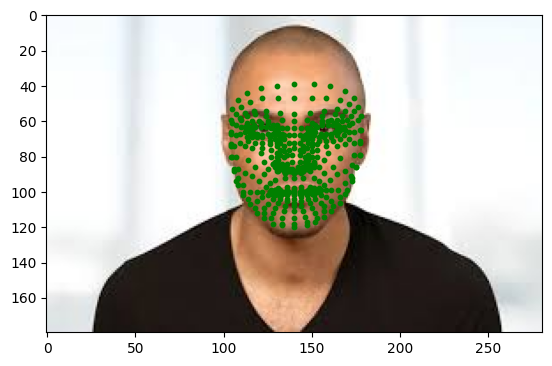

In [21]:
a,img1 = getPoints(img1.copy())
a = np.array(a)
plt.scatter(a[:,0],a[:,1],s=10,c='green')
plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
plt.show()

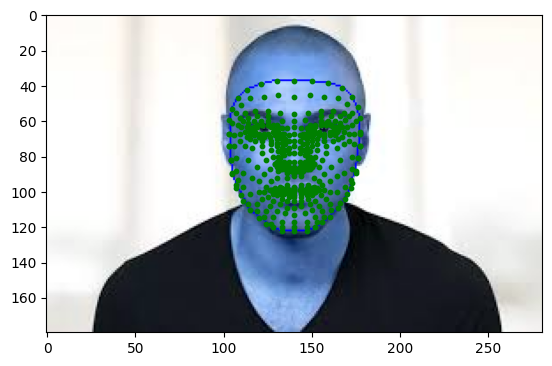

In [19]:
# landmarks
a,img1 = getPoints(img1.copy())
# convex hull
a = np.array(a)
hull1 = np.array(hull1)
cv2.drawContours(img1,[hull1],0,(255,0,0),1)
plt.scatter(a[:,0],a[:,1],s=10,c='green')
plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
plt.show()

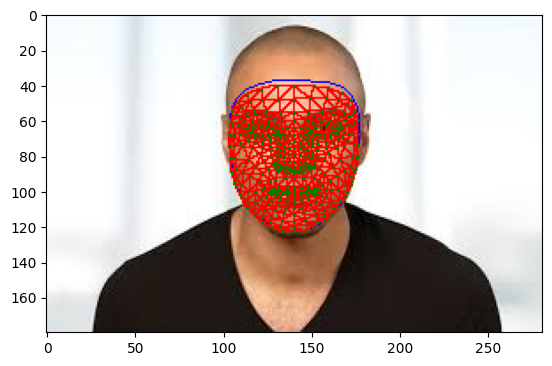

In [20]:
# landmarks
a,img1 = getPoints(img1.copy())
# convex hull
cv2.drawContours(img1,[hull1],0,(255,0,0),1)
# delaunay triangulation
h,w = img1.shape[:2]
subdiv = cv2.Subdiv2D((0,0,w,h))
subdiv.insert(a)
triangleList = subdiv.getTriangleList()

for t in triangleList:
    pts = t.reshape(-1,2).astype(np.int32)
    if (pts < 0).sum() or (pts[:,0]>w).sum() or (pts[:,1] > h).sum():
        continue
    cv2.polylines(img1,[pts],True,(0,0,255),1,cv2.LINE_4)


a = np.array(a)
hull1 = np.array(hull1)
plt.scatter(a[:,0],a[:,1],s=1,c='green')
plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
plt.show()



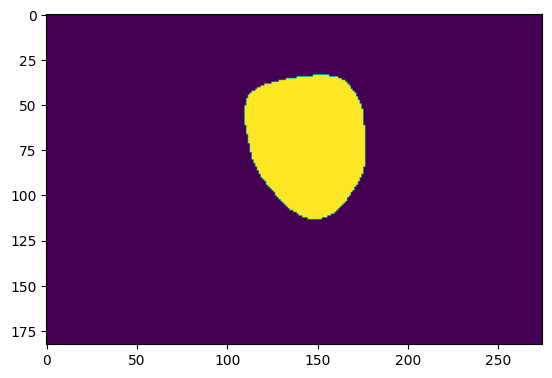

In [23]:
plt.imshow(mask)
plt.show()


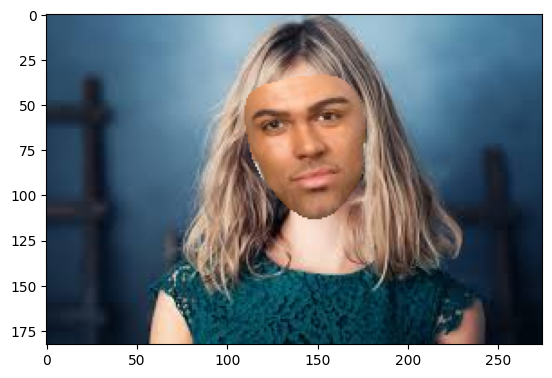

In [30]:
plt.imshow(np.uint8(img_draw))
plt.show()

In [37]:
import cv2
import mediapipe as mp
import numpy as np

# 선글라스 이미지 읽어오기
sunglass = cv2.imread('sunglasses.jpg', cv2.IMREAD_UNCHANGED)

# Mediapipe를 이용한 Face landmark detection
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)

# Dlib를 이용한 3D 모델링
model_points = np.array([
                         (0.0, 0.0, 0.0),             # Nose tip
                         (0.0, -330.0, -65.0),        # Chin
                         (-225.0, 170.0, -135.0),     # Left eye left corner
                         (225.0, 170.0, -135.0),      # Right eye right corner
                         (-150.0, -150.0, -125.0),    # Left Mouth corner
                         (150.0, -150.0, -125.0)      # Right mouth corner
                         ])

def put_sunglass(img, landmarks):
    # 랜드마크 좌표 추출
    nose_tip = landmarks[4][1], landmarks[4][0]
    chin = landmarks[10][1], landmarks[10][0]
    left_eye = landmarks[159]
    right_eye = landmarks[386]
    left_mouth = landmarks[5][1], landmarks[5][0]
    right_mouth = landmarks[6][1], landmarks[6][0]

    # 랜드마크를 이용한 얼굴의 각도 계산
    image_points = np.array([
                             nose_tip,     # Nose tip
                             chin,         # Chin
                             left_eye,     # Left eye left corner
                             right_eye,    # Right eye right corner
                             left_mouth,   # Left Mouth corner
                             right_mouth   # Right mouth corner
                             ], dtype="double")
    size = img.shape
    focal_length = size[1]
    center = (size[1]/2, size[0]/2)
    camera_matrix = np.array(
        [[focal_length, 0, center[0]],
         [0, focal_length, center[1]],
         [0, 0, 1]], dtype="double")
    dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
    success, rotation_vector, translation_vector = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)
    # 선글라스 이미지 크기 조정
    h, w = sunglass.shape[:2]
    sunglasses_width = int(abs(left_eye[0] - right_eye[0]) * 1.2)
    sunglasses_height = int(sunglasses_width * h / w)

    # 선글라스 회전 및 이동
    rotation_mat = cv2.Rodrigues(rotation_vector)[0]
    project_matrix = np.hstack((rotation_mat, translation_vector))
    camera_position = np.dot(-rotation_mat.T, translation_vector)
    yaw, pitch, roll = [np.radians(_) for _ in camera_position]

    # 선글라스 회전 변환
    rotation_matrix = np.zeros(shape=(3, 3))
    cosYaw = np.cos(yaw)
    sinYaw = np.sin(yaw)
    rotation_matrix[0, 0] = cosYaw
    rotation_matrix[0, 2] = sinYaw
    rotation_matrix[2, 0] = -sinYaw
    rotation_matrix[2, 2] = cosYaw

    cosPitch = np.cos(pitch)
    sinPitch = np.sin(pitch)
    rotation_matrix[1, 1] = cosPitch
    rotation_matrix[1, 2] = -sinPitch
    rotation_matrix[2, 1] = sinPitch
    rotation_matrix[2, 2] *= cosPitch

    cosRoll = np.cos(roll)
    sinRoll = np.sin(roll)
    rotation_matrix[0, 0] *= cosRoll
    rotation_matrix[0, 1] = -sinRoll
    rotation_matrix[1, 0] = sinRoll
    rotation_matrix[1, 1] *= cosRoll

    # 선글라스 이동 변환
    scale = sunglasses_width / w
    T = np.array([[1, 0, sunglasses_width/2],
                    [0, 1, sunglasses_height/2],
                    [0, 0, 0],
                    [0, 0, 1]])
                    
    R = np.array([
                [scale, 0, 0],
                [0, scale, 0],
                [0, 0, scale]
                ])
    M = T @ R @ np.hstack((rotation_matrix, translation_vector)).astype(np.float32)
    M = M[:3,:3]
    warped_sunglasses = cv2.warpPerspective(sunglass, M, (img.shape[1], img.shape[0]))
    warped_sunglasses
    # 이미지에 선글라스 합성
    mask = cv2.cvtColor(warped_sunglasses[:, :, :3], cv2.COLOR_BGR2GRAY)
    mask = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)[1]
    mask_inv = cv2.bitwise_not(mask)
    img_bg = cv2.bitwise_and(img, img, mask=mask_inv)
    sunglasses_fg = cv2.bitwise_and(warped_sunglasses[:, :, :3], warped_sunglasses[:, :, 3:], mask=mask)
    img = cv2.add(img_bg, sunglasses_fg)

    return img






In [38]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

mpFaceMesh = mp.solutions.face_mesh
faceMesh = mpFaceMesh.FaceMesh(max_num_faces=10,min_detection_confidence=0.7)

while True:
    ret, img = cap.read()
    img = cv2.flip(img, 1)

    # Face landmark detection
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = faceMesh.process(img_RGB)
    
    if results is not None:
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                landmarks = np.array(
                    [(lmk.x, lmk.y) for lmk in face_landmarks.landmark],
                    dtype=np.float32
                )
                # Apply sunglasses filter to face landmarks
                landmarks[:, :2] = np.round(landmarks[:, :2] * np.array([img.shape[1], img.shape[0]]))
                img = put_sunglass(img, landmarks)

    cv2.imshow('Sunglasses Filter', img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

ValueError: could not broadcast input array from shape (3,6,4) into shape (0,0,3)

In [39]:
cap.release()
cv2.destroyAllWindows()

In [50]:
def rotate_image(image, angle):
    """Rotate an image by a given angle in degrees."""
    # Get image size
    height, width = image.shape[:2]

    # Calculate image center
    center = (width / 2, height / 2)

    # Define rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Rotate image
    rotated_image = cv2.warpAffine(image, M, (width, height))

    return rotated_image

def extract_landmarks(image):
    with mp.solutions.face_mesh.FaceMesh() as face_mesh:
        results = face_mesh.process(image)
        if results.multi_face_landmarks:
            return results.multi_face_landmarks[0]
        else:
            return None
        
def put_sunglass(image, face_landmarks):
    sunglasses = cv2.imread("sunglasses.png", cv2.IMREAD_UNCHANGED)
    
    # Get the position and size of the sunglasses from the landmarks
    left_eye = face_landmarks.landmark[mp.solutions.face_mesh.FaceMesh.FaceMeshLandmark.LEFT_EYE]
    right_eye = face_landmarks.landmark[mp.solutions.face_mesh.FaceMesh.FaceMeshLandmark.RIGHT_EYE]
    nose_tip = face_landmarks.landmark[mp.solutions.face_mesh.FaceMesh.FaceMeshLandmark.NOSE_TIP]
    
    sunglasses_width = int(abs(right_eye.x - left_eye.x) * image.shape[1])
    sunglasses_height = int(sunglasses_width * sunglasses.shape[0] / sunglasses.shape[1])
    sunglasses_resized = cv2.resize(sunglasses, (sunglasses_width, sunglasses_height))
    
    # Calculate the rotation and translation for the sunglasses
    dx = right_eye.x - left_eye.x
    dy = right_eye.y - left_eye.y
    angle = -np.arctan2(dy, dx)
    sunglasses_rotated = rotate_image(sunglasses_resized, angle)
    sunglasses_center_x = int(nose_tip.x * image.shape[1])
    sunglasses_center_y = int(nose_tip.y * image.shape[0])
    tx = sunglasses_center_x - int(sunglasses_rotated.shape[1] / 2)
    ty = sunglasses_center_y - int(sunglasses_rotated.shape[0] / 3.5)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    sunglasses_translated = cv2.warpAffine(sunglasses_rotated, M, (image.shape[1], image.shape[0]))
    
    # Blend the sunglasses with the image
    alpha_s = sunglasses_translated[:, :, 3] / 255.0
    alpha_l = 1.0 - alpha_s
    for c in range(0, 3):
        image[:, :, c] = (alpha_s * sunglasses_translated[:, :, c] + alpha_l * image[:, :, c])
    
    return image


In [120]:
import time
import math
import numpy as np
import cv2

def morph_images(image1, image2, landmarks1, landmarks2, alpha=0.5):
    """
    Given two input images and corresponding landmarks, morphs the images into each other based on the specified alpha
    value, which controls the degree of morphing.
    """
    if type(landmarks1) is not np.ndarray:
         landmarks1 = np.array(landmarks1)
         landmarks2 = np.array(landmarks2)
    # Find Delaunay triangulation for points in both images
    triangulation = get_triangulation(landmarks1, landmarks2)
    
    # Create output image as a copy of image1
    morphed_image = np.copy(image1)
    morphed_image_roi = None
    # Loop through each triangle in the triangulation
    for triangle in triangulation: 
        # Get coordinates of the three vertices  in the two images
        x1, y1 = landmarks1[triangle[0]], landmarks1[triangle[1]], landmarks1[triangle[2]]
        x2, y2 = landmarks2[triangle[0]], landmarks2[triangle[1]], landmarks2[triangle[2]]
        
        # Calculate the affine transformation matrix for each triangle
        affine_matrix = cv2.getAffineTransform(np.float32([(x1[0], y1[0]), (x1[1], y1[1]), (x1[2], y1[2])]),
                                                np.float32([(x2[0], y2[0]), (x2[1], y2[1]), (x2[2], y2[2])]))
        
        # Create a mask for the triangle
        mask = np.zeros(image1.shape[:2], dtype=np.float32)
        cv2.fillConvexPoly(mask, np.array([(x1[0], y1[0]), (x1[1], y1[1]), (x1[2], y1[2])]), 1)
        
        # Warp the triangle from image1 to image2 using the affine transformation and mask
        warped_triangle = cv2.warpAffine(image1, affine_matrix, (image1.shape[1], image1.shape[0]), None,
                                         cv2.INTER_LINEAR, cv2.BORDER_REFLECT_101)
        warped_triangle = warped_triangle * mask[:, :, np.newaxis]
        
        # Warp the triangle from image2 to image1 using the affine transformation and mask
        inverse_affine_matrix = cv2.getAffineTransform(np.float32([(x2[0], y2[0]), (x2[1], y2[1]), (x2[2], y2[2])]),
                                                        np.float32([(x1[0], y1[0]), (x1[1], y1[1]), (x1[2], y1[2])]))
        warped_triangle2 = cv2.warpAffine(image2, inverse_affine_matrix, (image2.shape[1], image2.shape[0]), None,
                                          cv2.INTER_LINEAR, cv2.BORDER_REFLECT_101)
        warped_triangle2 = warped_triangle2 * mask[:, :, np.newaxis]
        
        # Add the two warped triangles together and blend them based on alpha value
        blended_triangle = (1 - alpha) * warped_triangle + alpha * warped_triangle2
        
        # Replace the triangle in the morphed image with the blended triangle
        morphed_image_roi = morphed_image[min(y1):max(y1), min(x1):max(x1)]
        blended_triangle_roi = blended_triangle[min(y1):max(y1), min(x1):max(x1)]
        # morphed_image_roi[np.where(blended_triangle_roi != 0)] = blended_triangle_roi[np.where(blended_triangle_roi != 0)]
        morphed_image_roi[min(y1):max(y1), min(x1):max(x1)][blended_triangle_roi != 0] = blended_triangle_roi[blended_triangle_roi != 0]

    return morphed_image_roi

    

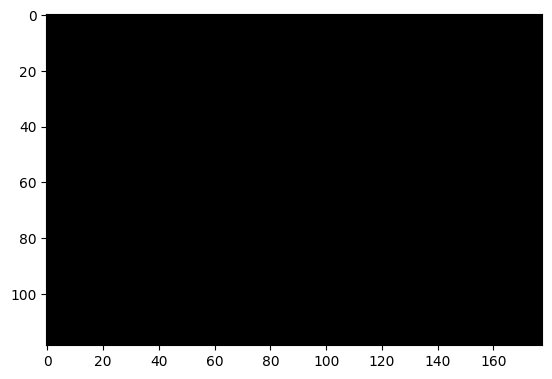

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [127]:
if type(landmarks1) is not np.ndarray:
         landmarks1 = np.array(landmarks1)
         landmarks2 = np.array(landmarks2)
         
triangle_list = get_triangulation(landmarks1, landmarks2)

vis_triangle_list(triangle_list)

None


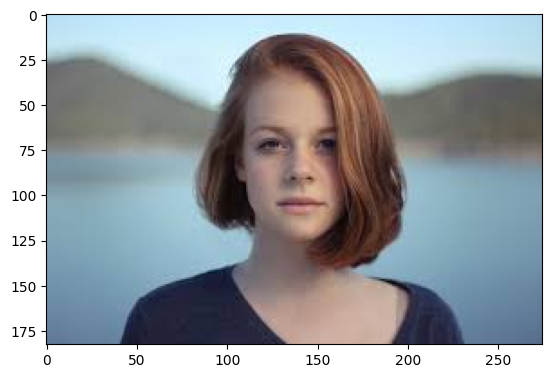

In [126]:
from devlib import *
import matplotlib.pyplot as plt

img1,img2 = imgs_read_rgb('./image.jpg','./image2.jpg')

landmarks1, landmarks2 = imgs_get_landmarks(img1,img2)
a = morph_images(img1,img2,landmarks1,landmarks2)
if a is None:
    print('None')
else:
    plt.imshow(a)
    plt.show()
plt.imshow(img1)
plt.show()

### Face Alignment

{0: (142, 100), 1: (141, 89), 2: (141, 93), 3: (136, 80), 4: (140, 86), 5: (139, 82), 6: (137, 73), 7: (116, 77), 8: (136, 66), 9: (135, 62), 10: (132, 48), 11: (143, 102), 12: (143, 103), 13: (143, 104), 14: (143, 104), 15: (143, 105), 16: (144, 107), 17: (144, 109), 18: (144, 112), 19: (141, 91), 20: (138, 91), 21: (104, 68), 22: (125, 78), 23: (122, 79), 24: (119, 79), 25: (115, 78), 26: (127, 76), 27: (120, 71), 28: (123, 71), 29: (117, 72), 30: (115, 73), 31: (113, 81), 32: (135, 118), 33: (115, 76), 34: (105, 81), 35: (110, 79), 36: (126, 90), 37: (139, 100), 38: (140, 104), 39: (136, 102), 40: (133, 104), 41: (137, 104), 42: (135, 105), 43: (130, 109), 44: (138, 90), 45: (137, 87), 46: (110, 71), 47: (130, 82), 48: (132, 91), 49: (131, 89), 50: (117, 92), 51: (137, 83), 52: (116, 66), 53: (112, 68), 54: (106, 62), 55: (129, 67), 56: (126, 71), 57: (128, 107), 58: (114, 107), 59: (134, 92), 60: (136, 92), 61: (131, 106), 62: (132, 106), 63: (110, 67), 64: (132, 92), 65: (122, 66)

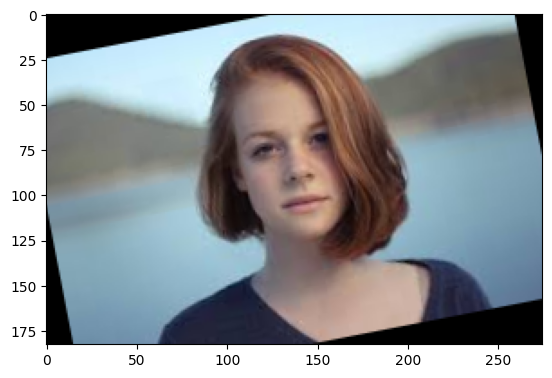

In [111]:
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp
import numpy as np

from devlib import *


mpFaceMesh = mp.solutions.face_mesh

# img1,img2 = imgs_read_rgb('./image.jpg','./image2.jpg')
img1 = imgs_read_rgb('./image.jpg')[0]
img1 = rotate_img(img1,11)
# landmarks1, landmarks2 = imgs_get_landmarks(img1,img2)
idx_to_coordinates,landmarks = get_idx_to_coordinates(img1)
plt.imshow(img1)
print(idx_to_coordinates)

[151.875  68.875] [121.125  75.125]


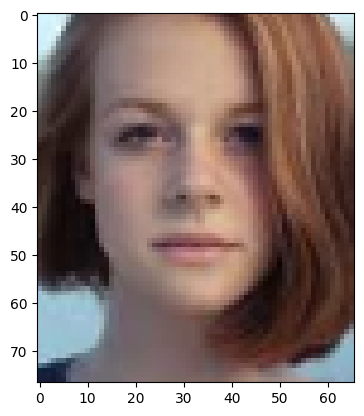

In [112]:
connections = [mpFaceMesh.FACEMESH_LEFT_EYE,mpFaceMesh.FACEMESH_RIGHT_EYE]
left_eye = get_connection_points(idx_to_coordinates,connections[0])
right_eye = get_connection_points(idx_to_coordinates,connections[1])

leftEyeCenter, rightEyeCenter, eyesCenter = get_eye_center(left_eye,right_eye)

print(leftEyeCenter, rightEyeCenter)

angle = get_angle(rightEyeCenter,leftEyeCenter)
scale = 0.7
M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
out_img = cv2.warpAffine(img1, M, (img1.shape[1], img1.shape[0]),
                            flags=cv2.INTER_CUBIC)
out_img = out_img[landmarks[:, 1].min():landmarks[:, 1].max(),
                landmarks[:, 0].min():landmarks[:, 0].max()]
plt.imshow(out_img)
plt.show()


[[ 0.73497227 -0.14938461 46.79946293]
 [ 0.14938461  0.73497227 -1.23431018]]


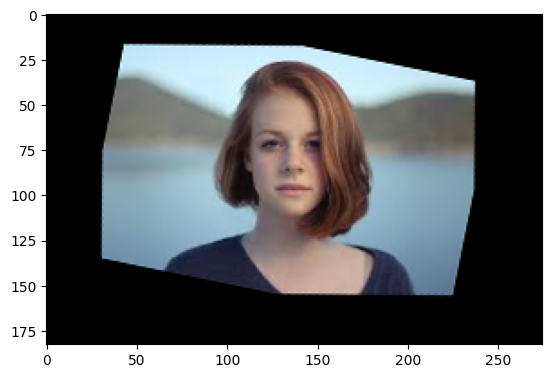

In [113]:

def align(img,idx_to_coordinates,scale):
    connections = [mpFaceMesh.FACEMESH_LEFT_EYE,mpFaceMesh.FACEMESH_RIGHT_EYE]
    left_eye = get_connection_points(idx_to_coordinates,connections[0])
    right_eye = get_connection_points(idx_to_coordinates,connections[1])

    leftEyeCenter, rightEyeCenter, eyesCenter = get_eye_center(left_eye,right_eye)
    angle = get_angle(rightEyeCenter,leftEyeCenter)

    M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
    print(M)
    out_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]),
                            flags=cv2.INTER_CUBIC)
    # out_img = out_img[landmarks[:, 1].min():landmarks[:, 1].max(),
    #             landmarks[:, 0].min():landmarks[:, 0].max()]
    plt.imshow(out_img)
    return out_img

img1= align(img1,idx_to_coordinates,0.75)

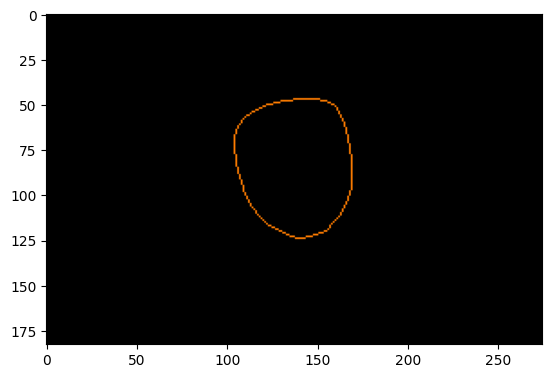

In [105]:

vis_coordinates(img1,idx_to_coordinates,connection=mpFaceMesh.FACEMESH_FACE_OVAL)